# Data exploration of a patient ECG

This notebook serves as a first contact with ECG data. For the purpose, the python package wfdb (https://wfdb.readthedocs.io/en/latest/) provides a set of tools which allow a very efficient way to read the files in the appropriate format as well as to annotate, plot and extract insights from them. Other packages will be used too, such as numpy, pandas and matplotlib, for numerical calculations, data processing and plotting options, respectively.

In [2]:
!pip install wfdb
import wfdb
from wfdb import processing
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 11.6 MB/s 


## Data lecture

For the moment, there is an example file from the patient dataset that will be loaded. This file is located inside the repository and corresponds to the patient 229. The folder includes 6 files: 2 different signals with the files .hea, .dat and .xyz. The library wfdb is optimized in such a way that it loads automatically all the information by giving the folder location as an input. For this work, I will load the signal corresponding to s0453_re sampling the first 10 seconds of the ECGs:

In [ ]:
patient = "patient229"
ecg = "s0453_re"
record = wfdb.rdrecord(patient+'/'+ecg, sampfrom=0, sampto=120000)  # The units in samp are miliseconds


The information provided in the header file is stored in record.comments. This information can be formatted into a dictionary structure by the use of the following function:

In [ ]:
def parse_coms(record):
    head_info = {}
    for item in record.comments:
        elem = item.split(':')
        head_info[elem[0]] = elem[1].lstrip()
    
    keys =  list(head_info.keys())
    ii_diag = [i for i, x in enumerate(keys) if x == "Diagnose"][0]
    ii_hemo = [i for i, x in enumerate(keys) if x == "Hemodynamics"][0]
    ii_ther = [i for i, x in enumerate(keys) if x == "Therapy"][0]

    keys_diag = [x for i, x in enumerate(keys) if ii_diag < i < ii_hemo]
    keys_hemo = [x for i, x in enumerate(keys) if ii_hemo < i < ii_ther]
    keys_ther = [x for i, x in enumerate(keys) if ii_ther < i]
    
    header_all = {"age":head_info["age"], 
                  "sex":head_info["sex"], 
                  "ECG date":head_info["ECG date"], 
                  "Diagnose":{}, 
                  "Hemodynamics":{}, 
                  "Therapy":{}}

    for key in keys_diag:
        header_all['Diagnose'][key] = head_info[key]
    for key in keys_hemo:
        header_all['Hemodynamics'][key] = head_info[key]
    for key in keys_ther:
        header_all['Therapy'][key] = head_info[key]
        
    return header_all

patient_info = parse_coms(record)
patient_info

{'age': '55',
 'sex': 'male',
 'ECG date': '13/06/1996',
 'Diagnose': {'Reason for admission': 'Healthy control',
  'Acute infarction (localization)': 'no',
  'Former infarction (localization)': 'no',
  'Additional diagnoses': 'no',
  'Smoker': 'unknown',
  'Number of coronary vessels involved': 'unknown',
  'Infarction date (acute)': 'n/a',
  'Previous infarction (1) date': 'n/a',
  'Previous infarction (2) date': 'n/a'},
 'Hemodynamics': {'Catheterization date': 'n/a',
  'Ventriculography': 'n/a',
  'Chest X-ray': 'n/a',
  'Peripheral blood Pressure (syst/diast)': 'n/a',
  'Pulmonary artery pressure (at rest) (syst/diast)': 'n/a',
  'Pulmonary artery pressure (at rest) (mean)': 'n/a',
  'Pulmonary capillary wedge pressure (at rest)': 'n/a',
  'Cardiac output (at rest)': 'n/a',
  'Cardiac index (at rest)': 'n/a',
  'Stroke volume index (at rest)': 'n/a',
  'Pulmonary artery pressure (laod) (syst/diast)': 'n/a',
  'Pulmonary artery pressure (laod) (mean)': 'n/a',
  'Pulmonary capillary

It is possible to get a glimpse of the signals by plotting them by using the functions of the library wfdb:

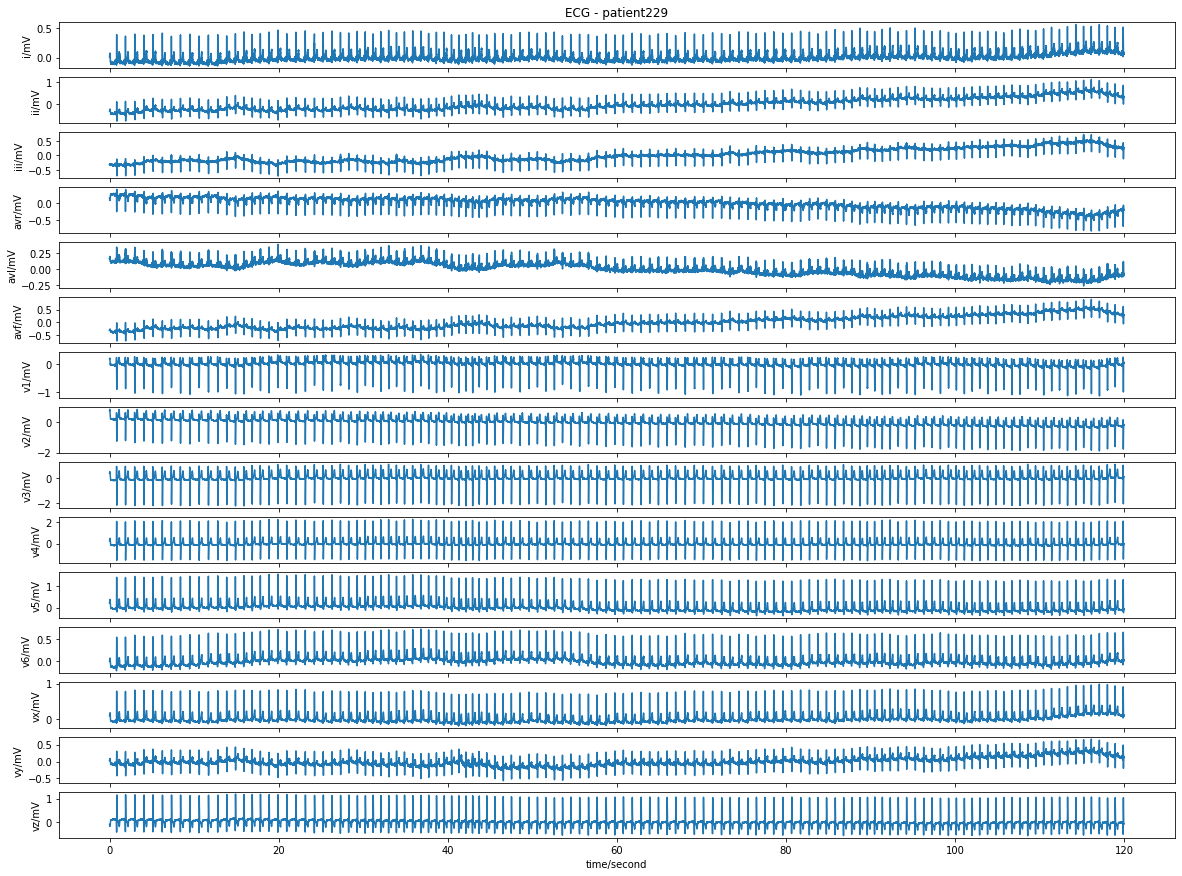

In [ ]:
wfdb.plot_wfdb(record=record, title='ECG - ' + patient, figsize = (20, 15))

Each channel corresponds to a lead measured by a set of electrodes and provides a different picture of the heart. Each lead signal is stored in records.p_signal in a column vector (that is, physical signal, which is loaded by default by using the sampling frequency of the device). An experienced doctor understands the information given by each of the leads and is able to find heart anomalies or different diseases by studying them. 

For example, if we just want to read the i, ii, iii leads:


Text(0.5, 1.0, 'First 3 leads, patient229')

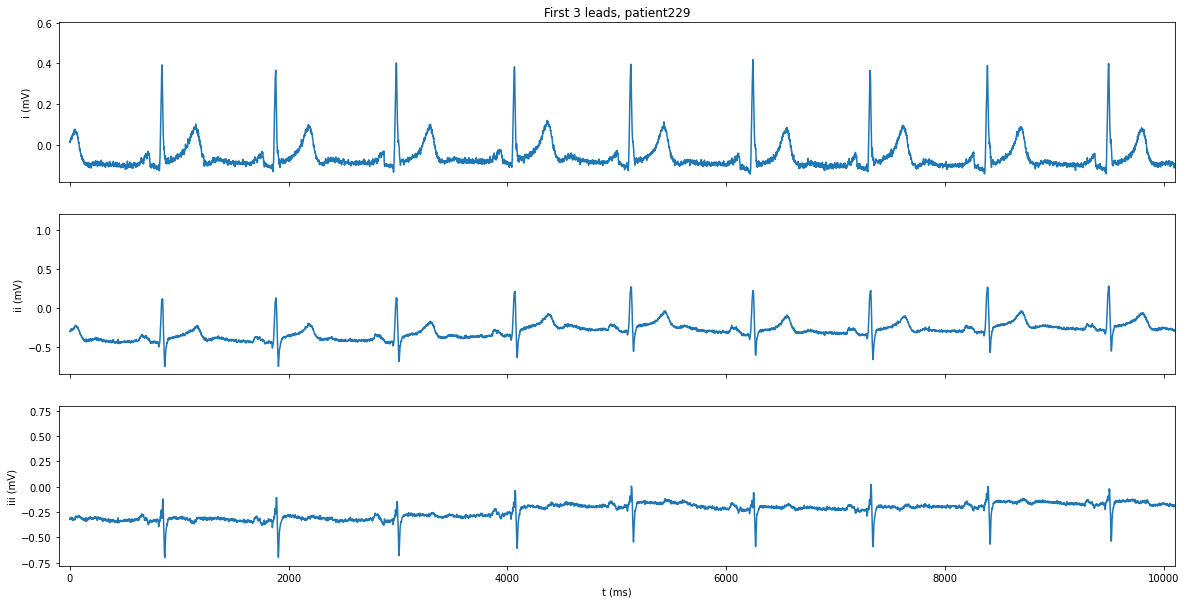

In [ ]:
f, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
for ii in range(3):
    ax[ii].plot(record.p_signal[:, ii])
    ax[ii].set_ylabel(record.sig_name[ii]+" (mV)")
    ax[ii].set_xlim([-100, 10100])
    
ax[2].set_xlabel('t (ms)')
ax[0].set_title('First 3 leads, ' + patient)

For the rest of the exercise, I am going to focus on the second lead (ii) as it presents sharper Q and S peaks. The first step I would take is to normalize the signal:

In [ ]:
channel = 1
signal = record.p_signal[:, channel]

n_signal = processing.normalize_bound(signal, lb=0, ub=1)


In order to measure the heart beats, I am going to identify the QRS complex in the signal. There are multiple QRS detection methods in literature (Eilers J., Chromik J. and Arnrich B. 2021: Choosing the Appropriate QRS Detector https://www.scitepress.org/Papers/2021/102346/102346.pdf), and the library wfdb provides two algorithms to detect it:

- GQRS: Trapezoid low-pass filtering + convolution with QRS filter. Learning phase then detection phase.
- XQRS: Band-pass filtering + moving wave integration + Ricker wavelet. Can conduct learning if desired.

I will perform and attempt with both methods:

In [ ]:
# Use the GQRS algorithm to detect QRS locations in the first channel
gqrs_inds = processing.gqrs_detect(sig=n_signal, fs=record.fs)
xqrs_inds = processing.xqrs_detect(sig=n_signal, fs=record.fs)


Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


The XQRS attempt does not work properly with the current configuration. Further exploration would be needed to understand why. On the other side, the GQRS algorithm has worked succesfully:

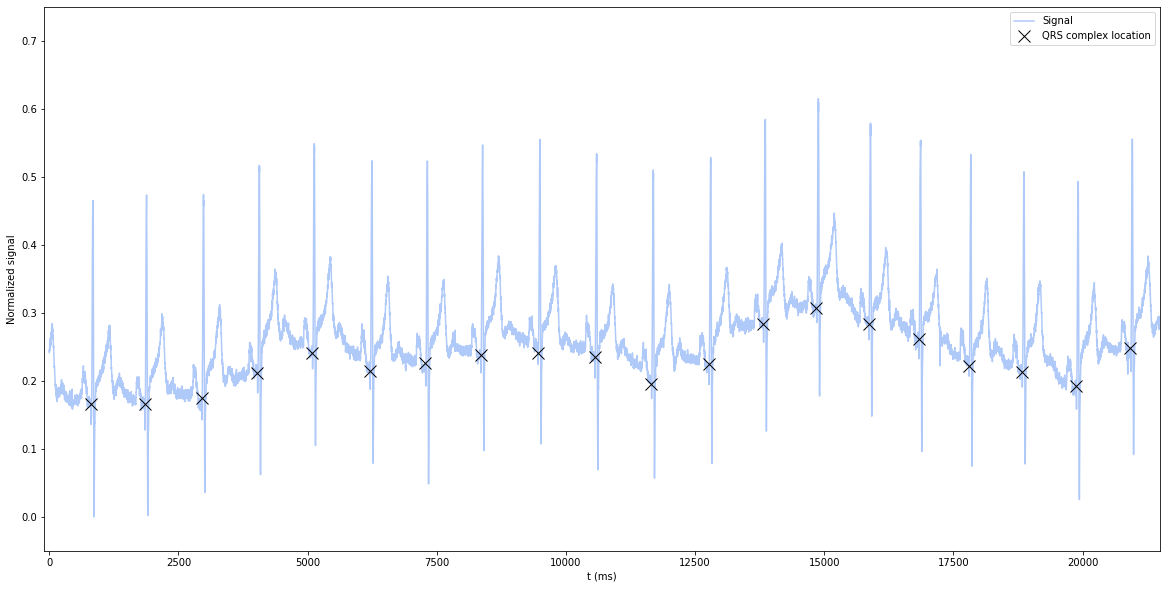

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(n_signal, color='#3979f0', label='Signal', alpha=0.4)
ax.plot(gqrs_inds, n_signal[gqrs_inds], 'x', color='k',
        label='QRS complex location', markersize=12)
ax.set_xlim([-100, 21500])
ax.set_ylim([-0.05, 0.75])
ax.set_xlabel('t (ms)')
ax.set_ylabel('Normalized signal')
plt.legend()

In order to match the location of the QRS with the local maxima (the R peaks), wfdb provides a function called correct_peaks. It takes as inputs the current location of the QRS complex, a search radius (the maximum horizontal shift allowed to find the local maxima) and a window size (the size of the moving average filter). The search radius can be defined by using a heart reate in bpm. A maximum possible bpm would provide the search radius needed for any ECG. A value of 200 bpms would be used here (https://www.webmd.com/heart-disease/heart-failure/watching-rate-monitor):

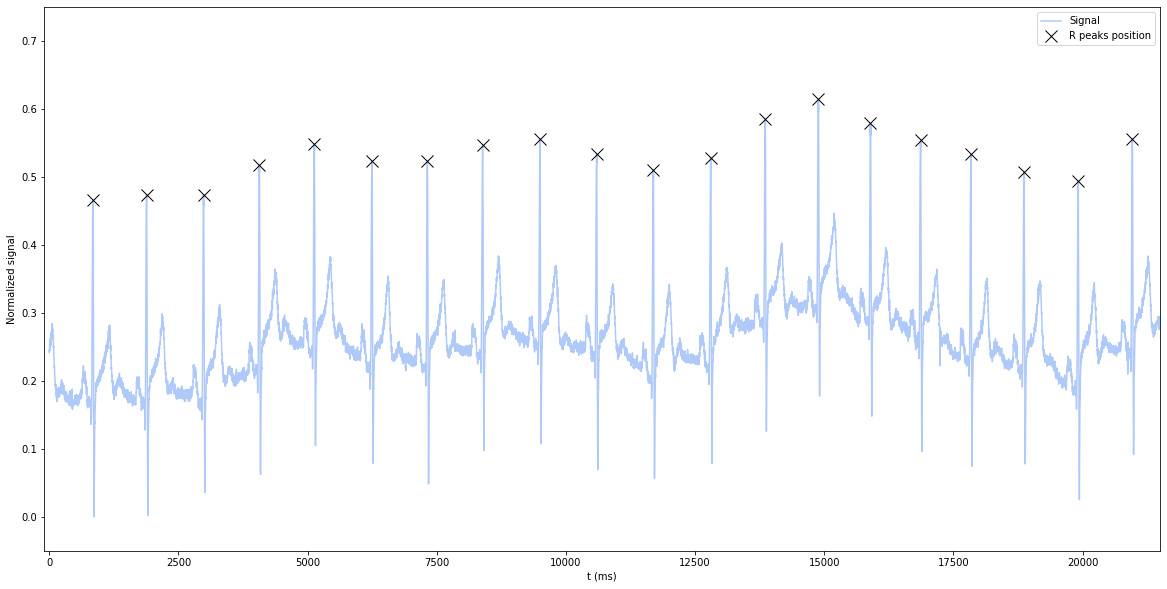

In [ ]:
max_hr = 200
search_radius = int(record.fs * 60 / max_hr)


corrected_peak_inds = processing.correct_peaks(signal, 
                                               peak_inds=gqrs_inds,
                                               search_radius=search_radius, 
                                               smooth_window_size=150)

f, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(n_signal, color='#3979f0', label='Signal', alpha=0.4)
ax.plot(corrected_peak_inds, n_signal[corrected_peak_inds], 'x', color='k',
        label='R peaks position', markersize=12)
ax.set_xlim([-100, 21500])
ax.set_ylim([-0.05, 0.75])
ax.set_xlabel('t (ms)')
ax.set_ylabel('Normalized signal')
plt.legend()


With these peaks it is possible to measure the RR duration, and to compute the total number of beats as well as the mean heart rate from them, in beats per minute:

In [ ]:
## TOTAL BEATS, AVERAGE HR, RR_DURATION, R

total_beats = len(corrected_peak_inds)
rr_duration = processing.calc_rr(qrs_locs=corrected_peak_inds, fs=record.fs, rr_units='seconds')
hr = processing.compute_hr(sig_len=signal.shape[0], qrs_inds=corrected_peak_inds, fs=record.fs)
mean_hr = processing.calc_mean_hr(rr_duration, fs = record.fs, rr_units='seconds')

print('Total beats in ' + str(int(len(signal)/1000)) + ' seconds: ' + str(total_beats))
print('Mean Heart Rate: ' + str(np.round(mean_hr,2)) + ' bps')

Total beats in 120 seconds: 121
Mean Heart Rate: 60.48 bps


Annotations can be created from the results obtained. In this case, I will label as normal beat every R peak location:

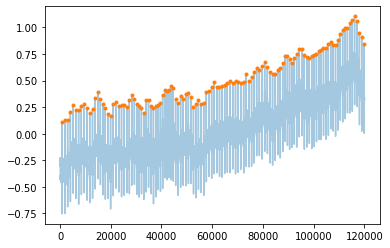

In [ ]:
ann1 = wfdb.Annotation(record_name='rec1', extension='atr',
                       sample=corrected_peak_inds, symbol = ['N' for ii in range(len(corrected_peak_inds))],
                       chan = channel*np.ones(len(corrected_peak_inds)), fs = record.fs)

wfdb.wrann(record_name=ecg, extension='atr',
           sample = corrected_peak_inds, symbol = ['N' for ii in range(len(corrected_peak_inds))],
           chan = channel*np.ones(len(corrected_peak_inds)),
           fs = record.fs)

plt.plot(signal, alpha=0.4)
plt.plot(ann1.sample, signal[ann1.sample], '.')


We can also plot the heart rate and the RR curve:

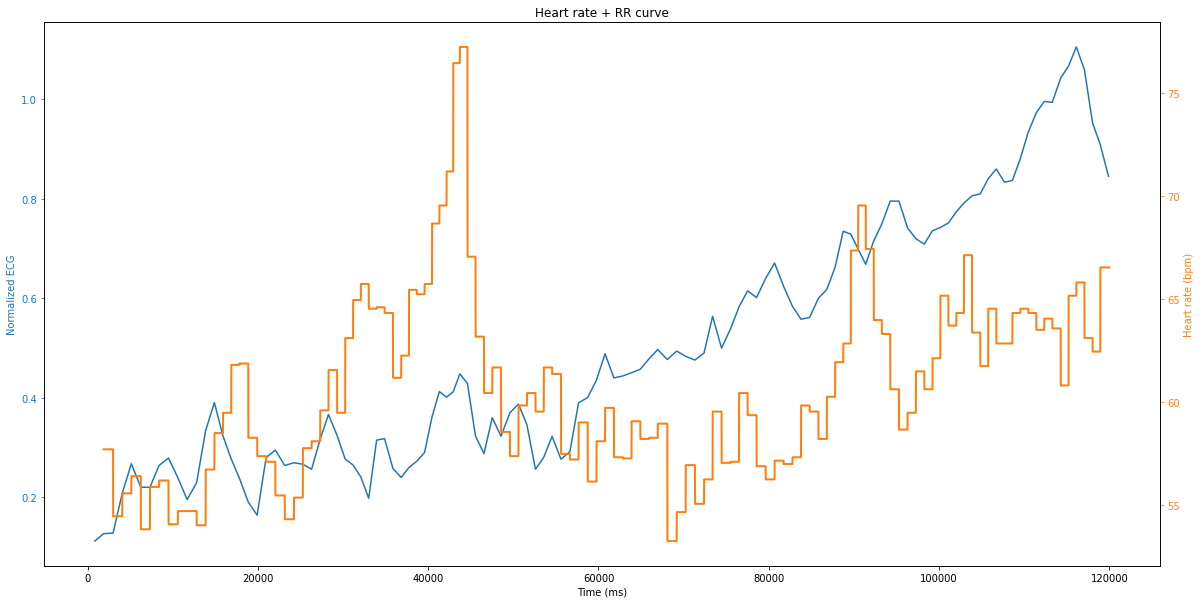

In [ ]:
def plot_hr_rr(sig, hr, peak_inds, fs, title, figsize=(20, 10)):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate       
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(peak_inds, signal[peak_inds], color='C0', label='RR curve')
    ax_right.plot(np.arange(len(hr)), hr, label='Heart rate', color='C1', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('Normalized ECG', color='C0')
    ax_right.set_ylabel('Heart rate (bpm)', color='C1')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='C0')
    ax_right.tick_params('y', colors='C1')
    plt.show()
    
plot_hr_rr(signal, hr, corrected_peak_inds, record.fs, 'Heart rate + RR curve')